# House Expenditure Analysis
## Motivation

Every two years, every member of the United States House of Representatives is up for election. After being elected, members of the House are given a set budget from the legislature itself to hire staff, buy office equipment, and defray other costs of legislating and addressing constituent concerns. While each office gets the same amount of money from Congress to spend on these purposes, congressional offices have discretion over how that allowance is actually spent, and we would like to see whether some spending patterns are associated with higher political success. 

## Getting/Formatting the Data
### ProPublica House Office Expenditure Data
For this project, we decided to use the [House Office Expenditure Data](https://www.propublica.org/datastore/dataset/house-office-expenditures) from ProPublica as it contains well formatted data about house expenditures from 2009 to 2018. The main downside of this dataset is that it is missing data from the most recent midterm election, but we still have almost 10 years of data to work with.

The ProPublica website requires an email to download the data. To programmatically access the datasets we are working with, we have included identical copies of the ProPublica dataset [here](https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/).

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
# just finna test with one of the files to see what happens
frames = []

# automate the dataframes from 2010 to 2020
for i in range(2010, 2021):
    for j in range(1, 5):
        df = pd.read_csv('./house-expenditure/' + str(i) + 'Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape')
        df.dropna(subset = ['BIOGUIDE_ID'], inplace=True)
        if not {'CATEGORY'}.issubset(df.columns): # For whatever reason, 2018Q2 has its category column mislabeled. 
            df.rename(columns={"SORT SUBTOTAL DESCRIPTION" : "CATEGORY"}, inplace=True)
        df["QUARTER"] = str(i) + 'Q' + str(j)
        frames.append(df)

# for 2021, we need to handle the data separately because we only have 3 quarters of disclosures
for j in range(1, 4):
    df = pd.read_csv('./house-expenditure/2021Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape')
    df.dropna(subset = ['BIOGUIDE_ID'], inplace=True)
    if not {'CATEGORY'}.issubset(df.columns): # For whatever reason, 2018Q2 has its category column mislabeled. 
        df.rename(columns={"SORT SUBTOTAL DESCRIPTION" : "CATEGORY"}, inplace=True)
    df["QUARTER"] = str(i) + 'Q' + str(j)
    frames.append(df)

house_data = pd.concat(frames)
house_data

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,BIOGUIDE_ID,OFFICE,QUARTER,CATEGORY,DATE,PAYEE,START DATE,END DATE,PURPOSE,AMOUNT,...,TRANSCODELONG,RECORDID,RECIP (orig.),PROGRAM,SORT SEQUENCE,AMOUNT,TRANSACTION DATE,DATA SOURCE,DOCUMENT,id
7597,A000014,HON. NEIL ABERCROMBIE,2010Q1,FRANKED MAIL,NaN,02Â­22 O4 NW201000101 UNITED STATES P...,01/03/10,01/31/10,FRANKED MAIL,126.58,...,NaN,NaN,02Â­22 O4 NW201000101 UNITED STATES P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7598,A000014,HON. NEIL ABERCROMBIE,2010Q1,FRANKED MAIL,NaN,03Â­25 O4 NW201000200 UNITED STATES P...,02/01/10,02/28/10,FRANKED MAIL,1112.16,...,NaN,NaN,03Â­25 O4 NW201000200 UNITED STATES P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7599,A000014,HON. NEIL ABERCROMBIE,2010Q1,PERSONNEL COMPENSATION,NaN,"ADAMS,LEE-ANN E",01/03/10,03/31/10,MILITARY LIAISON,21266.67,...,NaN,NaN,"ADAMS,LEE-ANN E",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7600,A000014,HON. NEIL ABERCROMBIE,2010Q1,PERSONNEL COMPENSATION,NaN,"ASSELBAYE, AMY",01/03/10,02/28/10,CHIEF OF STAFF,21750.00,...,NaN,NaN,"ASSELBAYE, AMY",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7601,A000014,HON. NEIL ABERCROMBIE,2010Q1,PERSONNEL COMPENSATION,NaN,"CHAN,GLORIA S",02/01/10,02/28/10,SHARED EMPLOYEE,4500.00,...,NaN,NaN,"CHAN,GLORIA S",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92425,Z000017,2021 HON. LEE M. ZELDIN,2020Q3,EQUIPMENT,,,,,OFFICE TOTALS:,317215.95,...,NaN,,NaN,OFFICIAL EXPENSES OF MEMBERS,GRAND TOTAL FOR ORGANIZATION,NaN,NaN,NaN,NaN,NaN
92426,Z000017,2021 HON. LEE M. ZELDIN,2020Q3,PERSONNEL COMPENSATION,,MCMAHON JORDANA A.,2021-07-01,2021-07-14,DISTRICT OFFICE PAID INTERN -,777.78,...,NaN,,NaN,INTERN ALLOWANCES,DETAIL,NaN,NaN,NaN,NaN,NaN
92427,Z000017,2021 HON. LEE M. ZELDIN,2020Q3,PERSONNEL COMPENSATION,,,,,PERSONNEL COMPENSATION TOTALS:,777.78,...,NaN,,NaN,INTERN ALLOWANCES,SUBTOTAL,NaN,NaN,NaN,NaN,NaN
92428,Z000017,2021 HON. LEE M. ZELDIN,2020Q3,PERSONNEL COMPENSATION,,,,,INTERN ALLOWANCES TOTALS:,777.78,...,NaN,,NaN,INTERN ALLOWANCES,SUBTOTAL,NaN,NaN,NaN,NaN,NaN


Try to figure out what categories we are working with and how these categories should be group into broader categories

In [110]:
from collections import defaultdict
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1

#apply add_set to the house_data
house_data.apply(add_set, axis = 1)
categories

defaultdict(<function __main__.<lambda>()>,
            {'FRANKED MAIL': 128370,
             'PERSONNEL COMPENSATION': 539204,
             'TRAVEL': 928273,
             'RENT, COMMUNICATION, UTILITIES': 598709,
             'PRINTING AND REPRODUCTION': 174619,
             'OTHER SERVICES': 211271,
             'SUPPLIES AND MATERIALS': 749782,
             'EQUIPMENT': 144454,
             'PERSONNEL BENEFITS': 122,
             'TRANSPORTATION OF THINGS': 754,
             'RENT COMMUNICATION UTILITIES': 18459,
             'RENT  COMMUNICATION  UTILITIES': 354294,
             'BENEFITS TO FORMER PERSONNEL': 5})

In [111]:
replace = {
    'RENT  COMMUNICATION  UTILITIES': 'RENT, COMMUNICATION, UTILITIES',
    'RENT COMMUNICATION UTILITIES': 'RENT, COMMUNICATION, UTILITIES'
}
house_data.replace(to_replace=replace, value=None, inplace=True)

In [112]:
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1
      
house_data.apply(add_set, axis = 1)
categories

defaultdict(<function __main__.<lambda>()>,
            {'FRANKED MAIL': 128370,
             'PERSONNEL COMPENSATION': 539204,
             'TRAVEL': 928273,
             'RENT, COMMUNICATION, UTILITIES': 971462,
             'PRINTING AND REPRODUCTION': 174619,
             'OTHER SERVICES': 211271,
             'SUPPLIES AND MATERIALS': 749782,
             'EQUIPMENT': 144454,
             'PERSONNEL BENEFITS': 122,
             'TRANSPORTATION OF THINGS': 754,
             'BENEFITS TO FORMER PERSONNEL': 5})

### Harvard Dataverse U.S. House Elections Dataset
We are using a dataset from the Harvard DataVerse which can be found [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2). This dataset details election returns for each of the representatives we are looking at.

In [113]:
election_data = pd.read_csv('./house-expenditure/1976-2020-house.csv')

# filter out the years before 2009 and after 2018
election_data = election_data[election_data['year'] >= 2009]
election_data = election_data[election_data['year'] <= 2020]

election_data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version,fusion_ticket
22553,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,DAVID WALTER,CONSTITUTION,False,TOTAL,26357,156281,False,20220331,False
22554,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,JO BONNER,REPUBLICAN,False,TOTAL,129063,156281,False,20220331,False
22555,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,WRITEIN,NaN,True,TOTAL,861,156281,False,20220331,False
22556,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,False,BOBBY BRIGHT,DEMOCRAT,False,TOTAL,106865,219028,False,20220331,False
22557,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,False,MARTHA ROBY,REPUBLICAN,False,TOTAL,111645,219028,False,20220331,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31098,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,LYNNETTE GREY BULL,DEMOCRAT,False,TOTAL,66576,278503,False,20220331,False
31099,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,OVERVOTES,NaN,False,TOTAL,1274,278503,False,20220331,False
31100,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,RICHARD BRUBAKER,LIBERTARIAN,False,TOTAL,10154,278503,False,20220331,False
31101,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,UNDERVOTES,NaN,False,TOTAL,6337,278503,False,20220331,False


### Congress Bioguide IDs

It turns out that Congress helpfully assigns each member of the House a unique ID based on the first initial of their last name, followed by a number. Since this is a unique identifier, that makes a lot of the pre-processing a lot easier. Here, we can scrape the congressional webpage with each past and current member's bioguide ID and add it to our dataframe. The data is formatted as an HTML table, which makes the processing very simple, but we need to use some regular expressions to separate each member's first and last name. 

In [114]:
import requests
from bs4 import BeautifulSoup
raw = requests.get("https://www.congress.gov/help/field-values/member-bioguide-ids")
soup = BeautifulSoup(raw.text, 'lxml')
table = soup.find('table')

# Since the entire thing is a formatted table, read it directly into a pandas dataframe
tabledf = pd.read_html(str(table))
tabledf = tabledf[0]
tabledf.dropna(subset = ['Member'], inplace=True)
tabledf.reset_index(drop=True, inplace=True)
members = tabledf['Member'].str.extractall("(.*), (.*) \((.*) - (.*)\)")

members.reset_index(drop=True, inplace=True)
members.rename(columns={0 : 'LASTNAME', 1: "FIRSTNAME", 2: "PARTY", 3: "STATE"}, inplace=True)
members['BIOGUIDE_ID'] = tabledf['Member ID']
members

,LASTNAME,FIRSTNAME,PARTY,STATE,BIOGUIDE_ID
0,Abdnor,James,Republican,South Dakota,A000009
1,Abercrombie,Neil,Democratic,Hawaii,A000014
2,Abourezk,James,Democratic,South Dakota,A000017
3,Abraham,Ralph Lee,Republican,Louisiana,A000374
4,Abraham,Spencer,Republican,Michigan,A000355
...,...,...,...,...,...
2422,Zinke,Ryan K.,Republican,Montana,Z000018
2423,Zion,Roger H.,Republican,Indiana,Z000010
2424,Zorinsky,Edward,Democratic,Nebraska,Z000013
2425,Zschau,Edwin V. W.,Republican,California,Z000014


## Terms served

Unfortunately, the election returns do not include the number of terms served by each member of the house. While this would be possible to calculate, factoring in resignations and other special circumstances makes this a difficult task. To make things easier, we can use a small JSON dataset of the number of terms served by each member of the house. 

In [115]:
import datetime

term_data = []
column_names = ['BIOGUIDE_ID','TERMS']

for url in ['https://theunitedstates.io/congress-legislators/legislators-current.json','https://theunitedstates.io/congress-legislators/legislators-historical.json']:
    r = requests.get(url)
    json_data = r.json()

    for json_el in json_data:
        number_of_terms = 0
        for term in json_el['terms']:
            start_date = datetime.datetime.strptime(term['start'], '%Y-%m-%d')
            # Make sure we are not looking at terms served after the period we are analysing
            if start_date.year < 2020:
                number_of_terms += 1
        term_data.append([json_el['id']['bioguide'], len(json_el['terms'])])

us_io_data = pd.DataFrame(term_data, columns=column_names)
us_io_data

,BIOGUIDE_ID,TERMS
0,B000944,10
1,C000127,5
2,C000141,13
3,C000174,9
4,C001070,3
...,...,...
12585,H001088,2
12586,Y000033,25
12587,F000449,9
12588,V000132,5


## K-Nearest Neighbors Model
### General Pre-processing
We aim to build 3 separate K-NN models to test 3 separate hypothesis. Before we delve into the specifics for each model we are doing some general preprocessing that will be useful for all 3 models. Firstly we are building a dataframe to represent a candidate's spending in a given quarter in a single row. We will do this by making a column for each spending category and listing the total amount spend for that category in a given quarter. This will essentially make each row a vector representing one quarter for one candidate.

In [116]:
import numpy as np
quarters = house_data['QUARTER'].unique()
categories = house_data['CATEGORY'].unique()
spending_data = []

for quarter in quarters:
    hd_by_quarter = house_data[house_data['QUARTER'] == quarter]
    bio_ids = hd_by_quarter['BIOGUIDE_ID'].unique()

    spending_per_candidate = hd_by_quarter.groupby(['BIOGUIDE_ID','CATEGORY'])['AMOUNT'].sum()
        
    for bio_id in bio_ids:
        row = [bio_id]
        for category in categories:
            if category in spending_per_candidate[bio_id]:
                row.append(spending_per_candidate[bio_id][category])
            else:
                row.append(0)
        spending_data.append(row)
        
quarter_spending_df = pd.DataFrame(spending_data,columns = ["BIOGUIDE_ID"] + categories.tolist())
quarter_spending_df

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL
0,A000014,1498.61,259540.31,10891.59,21084.39,43.90,8348.02,4661.75,981.30,0.0,0.0,0.0
1,A000022,21011.90,242972.84,3655.22,33422.01,9794.18,21341.00,17776.34,2033.33,0.0,0.0,0.0
2,A000055,1671.92,264937.16,10360.45,19145.14,2130.92,11644.95,8005.85,601.50,0.0,0.0,0.0
3,A000364,85906.29,199660.40,7925.65,27119.41,75410.20,30479.70,6095.27,3894.33,0.0,0.0,0.0
4,A000358,40746.81,259704.20,6721.87,24703.34,45627.10,12367.41,6997.48,3610.12,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20715,W000827,-48.90,343750.00,3554.82,63428.86,612.92,20806.60,330.84,385771.82,0.0,0.0,0.0
20716,Y000062,279.42,554398.70,3576.12,112862.60,38.00,6924.42,30705.18,568213.36,0.0,0.0,0.0
20717,Y000065,740.14,702125.06,4916.98,37383.60,800.00,3151.28,4912.34,822292.96,0.0,0.0,0.0
20718,Y000033,105.16,764444.52,55760.86,42935.26,79.90,37800.00,3949.54,915982.56,0.0,0.0,0.0


Additionally, we want to vertically normalize the dataset because some categories tend to have more spending than others. Without normalizing this data we might miss out on patterns involving low spending categories because they will have a smaller contribution to a data point's "distance" to other points.

In [117]:
# Takes in a dataframe and a list of columns to normalize
def normalize(df, categories):
    # get the mean and std of each column
    mean = quarter_spending_df.mean()
    std = quarter_spending_df.std()

    def normalize_helper(row):
        for category in categories:
            if std[category] == 0:
                row[category] = (row[category] - mean[category])
            else:
                row[category] = (row[category] - mean[category]) / std[category]
        return row
    return df.apply(normalize_helper, axis=1)
quarter_spending_df = normalize(quarter_spending_df, categories)
quarter_spending_df

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL
0,A000014,-0.391938,-0.242109,-0.335008,-0.414898,-0.450426,-0.431788,-0.190419,-0.573439,-0.001998,-0.040833,0.0
1,A000022,0.502667,-0.312801,-0.838251,0.000708,-0.096322,0.442242,-0.017257,-0.570688,-0.001998,-0.040833,0.0
2,A000055,-0.383993,-0.219082,-0.371946,-0.480224,-0.374631,-0.210006,-0.146265,-0.574433,-0.001998,-0.040833,0.0
3,A000364,3.477811,-0.497612,-0.541270,-0.211602,2.286675,1.056997,-0.171491,-0.565820,-0.001998,-0.040833,0.0
4,A000358,1.407432,-0.241410,-0.624986,-0.292990,1.205033,-0.161406,-0.159579,-0.566563,-0.001998,-0.040833,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20715,W000827,-0.462885,0.117206,-0.845234,1.011521,-0.429761,0.406293,-0.247604,0.433050,-0.001998,-0.040833,0.0
20716,Y000062,-0.447833,1.016026,-0.843752,2.676750,-0.450641,-0.527553,0.153452,0.910259,-0.001998,-0.040833,0.0
20717,Y000065,-0.426711,1.646361,-0.750504,0.134158,-0.422967,-0.781370,-0.187111,1.574851,-0.001998,-0.040833,0.0
20718,Y000033,-0.455822,1.912273,2.785360,0.321172,-0.449119,1.549429,-0.199823,1.819913,-0.001998,-0.040833,0.0


Finally, we want to combine this spending formation with data about the candidate. Specifically data about the political party they are affiliated with as well as the state they represent.

In [118]:
# Left join the spending data with the candidate data
spending_member_info = quarter_spending_df.merge(members, on="BIOGUIDE_ID")
spending_member_info

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,-0.391938,-0.242109,-0.335008,-0.414898,-0.450426,-0.431788,-0.190419,-0.573439,-0.001998,-0.040833,0.0,Abercrombie,Neil,Democratic,Hawaii
1,A000014,-0.425417,-0.751597,-0.736748,-0.486954,-0.447487,-0.256962,-0.207101,-0.574488,-0.001998,-0.040833,0.0,Abercrombie,Neil,Democratic,Hawaii
2,A000014,-0.460643,-1.349545,-1.092448,-1.125149,-0.428761,-0.825450,-0.251972,-0.576006,-0.001998,-0.040833,0.0,Abercrombie,Neil,Democratic,Hawaii
3,A000014,-0.460643,-1.349616,-1.092448,-1.125149,-0.452021,-0.993355,-0.251972,-0.576006,-0.001998,-0.040833,0.0,Abercrombie,Neil,Democratic,Hawaii
4,A000014,-0.460643,-1.349545,-1.092796,-1.125149,-0.452021,-0.993355,-0.251972,-0.576006,-0.001998,-0.040833,0.0,Abercrombie,Neil,Democratic,Hawaii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20683,C001125,-0.460643,-0.686405,-0.983710,-0.679615,-0.372413,-0.993355,2.012250,-0.576006,-0.001998,-0.040833,0.0,Carter,Troy,Democratic,Louisiana
20684,C001125,-0.460643,0.268177,0.003657,0.784821,-0.158097,-0.104457,0.004158,0.689664,-0.001998,-0.040833,0.0,Carter,Troy,Democratic,Louisiana
20685,S001218,-0.463798,-1.026948,-1.092448,-1.125149,-0.452021,-0.993355,-0.250769,-0.375052,-0.001998,-0.040833,0.0,Stansbury,Melanie Ann,Democratic,New Mexico
20686,S001218,-0.463724,0.670236,1.302408,-0.705039,-0.273036,-0.354919,-0.145231,0.831756,-0.001998,-0.040833,0.0,Stansbury,Melanie Ann,Democratic,New Mexico


### K-NN Model to Predict Candidate
We would like test if the spending of a candidate is related to their previous spending. Our null hypothesis is that `a candidate's spending has no relation to their spending in other quarters`. To test this hypothesis, we aim to train a K-NN model and test its hypothesis. If the model performs significantly better than random chance, we will have good reason to reject the null hypothesis.

#### Model Specific Pre-processing
Before training the model, we need to ensure that each candidate in the dataset has an appropriate number of datapoints. Since we plan to use 10-fold cross validation, we want to ensure that each fold has atleast 1 point for each candidate. After looking through the dataset, we settled on having a minimum of 20 datapoints for each house member to allow for about 2 points in each fold. We also settled on this number because it does not reduce the size of our dataset too much.

In [147]:
spending_member_info_candidates_arr = []
for bio_id in spending_member_info["BIOGUIDE_ID"].unique():
    count = sum(sum([spending_member_info["BIOGUIDE_ID"] == bio_id]))
    if count >= 20:
        spending_member_info_candidates_arr.append(spending_member_info[spending_member_info["BIOGUIDE_ID"] == bio_id])
spending_member_info_candidates = pd.concat(spending_member_info_candidates_arr)
(len(spending_member_info_candidates["BIOGUIDE_ID"].unique()),len(spending_member_info["BIOGUIDE_ID"].unique()))

(471, 933)

#### Selecting Hyperparameters


In [148]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = train_test_split(spending_member_info_candidates[categories],spending_member_info_candidates["BIOGUIDE_ID"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.06293174283852322

In [122]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.07558996167158674

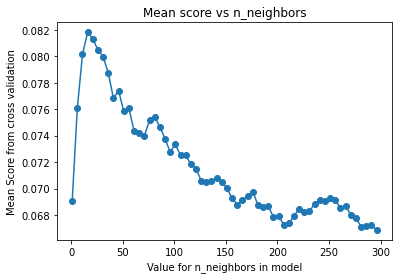

In [123]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier(weights='distance')
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

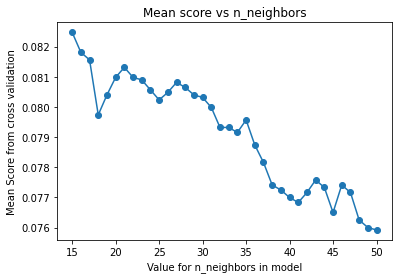

In [124]:
knn_model = KNeighborsClassifier(weights='distance')
test_k = range(15,50+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [125]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

15

In [126]:
knn_model = KNeighborsClassifier(weights='distance', n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.0744151319064211

Indicitive of clustering based on candidate expenditure

### K-nn - Predicting party
Our goal is to build a model that accurately predicts the party a candidate belongs to based on their average quarterly budget. If we are able to accurately do this 

In [127]:
spending_member_info_combined = spending_member_info.groupby("BIOGUIDE_ID").mean()
# non numerical data does not get returned by mean() so we do a left join with the member table to get back the missing data
spending_member_info_combined = spending_member_info_combined.merge(members, on="BIOGUIDE_ID")
spending_member_info_combined

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,-0.439857,-1.008483,-0.869890,-0.855460,-0.446143,-0.700182,-0.230687,-0.575189,-0.001998,-0.040833,0.0,Abercrombie,Neil,Democratic,Hawaii
1,A000022,-0.103595,-0.524438,-0.853022,-0.264055,-0.293391,-0.230185,-0.118245,-0.565770,-0.001998,0.563125,0.0,Ackerman,Gary L.,Democratic,New York
2,A000055,-0.326470,0.218289,0.748805,-0.016961,-0.321237,-0.113117,-0.023785,0.114221,-0.001998,-0.040833,0.0,Aderholt,Robert B.,Republican,Alabama
3,A000148,-0.453338,0.572019,-0.355615,1.310970,-0.225054,0.014117,-0.037597,0.861940,-0.001998,-0.040833,0.0,Auchincloss,Jake,Democratic,Massachusetts
4,A000210,0.041162,-0.586084,-0.849460,-0.245273,-0.202061,-0.169609,-0.185621,-0.562913,-0.001998,-0.040833,0.0,Andrews,Robert E.,Democratic,New Jersey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,Y000064,0.141552,-0.457496,-0.082094,-0.542177,0.198280,-0.248551,-0.180442,-0.571207,-0.001998,-0.040833,0.0,Young,Todd,Republican,Indiana
929,Y000065,-0.271747,-0.066451,0.127232,-0.152667,-0.190796,-0.036926,-0.080539,0.064651,-0.001998,-0.040833,0.0,Yoho,Ted S.,Republican,Florida
930,Y000066,0.056159,-0.340876,0.084042,-0.153210,-0.131694,-0.129097,-0.086530,-0.117077,-0.001998,-0.037097,0.0,Young,David,Republican,Iowa
931,Z000017,0.629334,0.477587,-0.046988,0.582069,0.322944,0.519221,-0.062521,0.611285,-0.001998,0.987060,0.0,Zeldin,Lee M.,Republican,New York


Issolate just Democratic and Republican members as the other parties don't have enough data to train on.

In [128]:
spending_member_info_2_party_dup_mems = pd.concat([spending_member_info[spending_member_info["PARTY"] == 'Republican'], spending_member_info[spending_member_info["PARTY"] == 'Democratic']])
spending_member_info_2_party_dup_mems["PARTY"].unique()

array(['Republican', 'Democratic'], dtype=object)

In [129]:
spending_member_info_2_party = spending_member_info_2_party_dup_mems.groupby("BIOGUIDE_ID").mean()
spending_member_info_2_party = spending_member_info_2_party.merge(members, on="BIOGUIDE_ID")
spending_member_info_2_party

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,-0.439857,-1.008483,-0.869890,-0.855460,-0.446143,-0.700182,-0.230687,-0.575189,-0.001998,-0.040833,0.0,Abercrombie,Neil,Democratic,Hawaii
1,A000022,-0.103595,-0.524438,-0.853022,-0.264055,-0.293391,-0.230185,-0.118245,-0.565770,-0.001998,0.563125,0.0,Ackerman,Gary L.,Democratic,New York
2,A000055,-0.326470,0.218289,0.748805,-0.016961,-0.321237,-0.113117,-0.023785,0.114221,-0.001998,-0.040833,0.0,Aderholt,Robert B.,Republican,Alabama
3,A000148,-0.453338,0.572019,-0.355615,1.310970,-0.225054,0.014117,-0.037597,0.861940,-0.001998,-0.040833,0.0,Auchincloss,Jake,Democratic,Massachusetts
4,A000210,0.041162,-0.586084,-0.849460,-0.245273,-0.202061,-0.169609,-0.185621,-0.562913,-0.001998,-0.040833,0.0,Andrews,Robert E.,Democratic,New Jersey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,Y000064,0.141552,-0.457496,-0.082094,-0.542177,0.198280,-0.248551,-0.180442,-0.571207,-0.001998,-0.040833,0.0,Young,Todd,Republican,Indiana
927,Y000065,-0.271747,-0.066451,0.127232,-0.152667,-0.190796,-0.036926,-0.080539,0.064651,-0.001998,-0.040833,0.0,Yoho,Ted S.,Republican,Florida
928,Y000066,0.056159,-0.340876,0.084042,-0.153210,-0.131694,-0.129097,-0.086530,-0.117077,-0.001998,-0.037097,0.0,Young,David,Republican,Iowa
929,Z000017,0.629334,0.477587,-0.046988,0.582069,0.322944,0.519221,-0.062521,0.611285,-0.001998,0.987060,0.0,Zeldin,Lee M.,Republican,New York


Here we are making a KNN with default values to see if the model does better than random chance.

In [130]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_2_party[categories], spending_member_info_2_party["PARTY"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.6675155279503107

We get an accurary score higher than 50% which looks promising.

We can now try to tune the hyperparameters. Starting with the way points in the k-nn model are weighted. Uniform weighting gives all k nearest points equal weighting, while the distance weighting weighs points by the inverse of their distance. The default weight in scikit learn is uniform so we are testing the distance weighting method.

In [131]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.6746583850931678

It looks like both weighting methods produce very similar accuracies. As a result, we will use the default that scikit learn uses as there is likely good reason it is the default and we do not have a good reason to change it.

Next we are going to look at the number of nearest neighbors and see how that changes our accuracy.

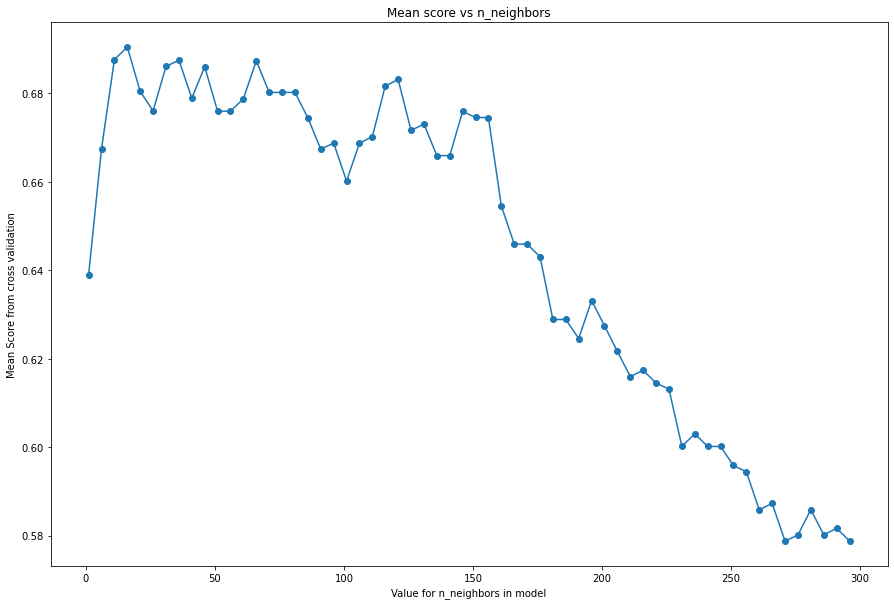

In [132]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier()
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

# Code to change default plot size:
plt.rcParams['figure.figsize'] = [15, 10]

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

From the graph it seems like the ideal number of neighbors is in the range between 10 and 50. We can do a grid search of all values in that range to better visualize the space.

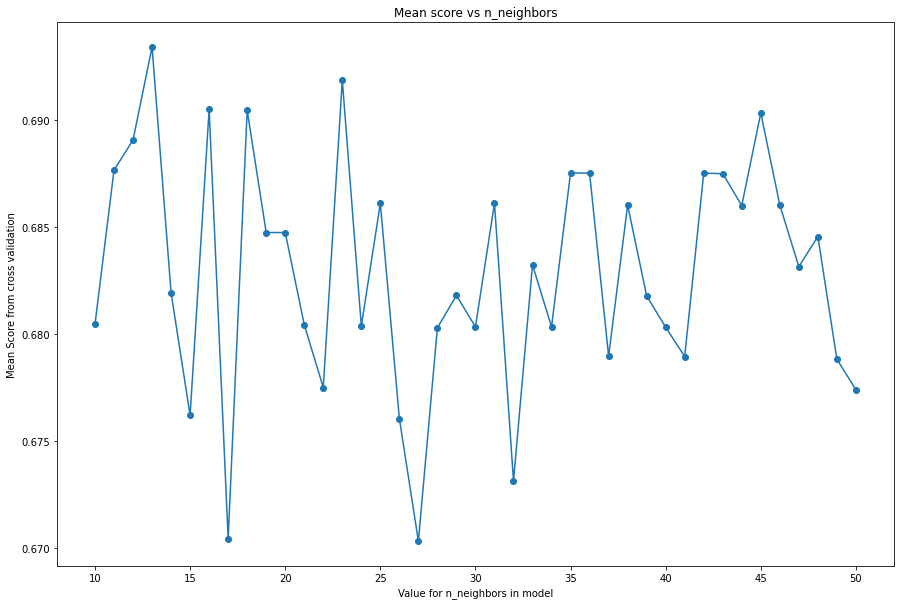

In [133]:
knn_model = KNeighborsClassifier()
test_k = range(10,50+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [134]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

13

There seems to be a peak in the data around $k=25$ so that will be the value for k we will use in the final model.

With these hyper parameters set, we can evaulate our model's performance on the test set.

In [135]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.7381974248927039

### K-nn - Predicting State

In [136]:
# Verifying we have enough data for each state

# state_count = {}
# for state in spending_member_info["STATE"].unique():
#     state_count[state] = sum(sum([spending_member_info["STATE"] == state]))
# state_count

We have a lot more data for states with more representitives

In [137]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_2_party[categories],spending_member_info_2_party["STATE"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


0.08457556935817805

We get an accurary score higher than 1/56 which looks promising.

We can now try to tune the hyperparameters. Starting with the way points in the k-nn model are weighted. Uniform weighting gives all k nearest points equal weighting, while the distance weighting weighs points by the inverse of their distance. The default weight in scikit learn is uniform so we are testing the distance weighting method.

In [138]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


0.0831262939958592

It looks like both weighting methods produce very similar accuracies. As a result, we will use the default that scikit learn uses as there is likely good reason it is the default and we do not have a good reason to change it.

Next we are going to look at the number of nearest neighbors and see how that changes our accuracy.

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


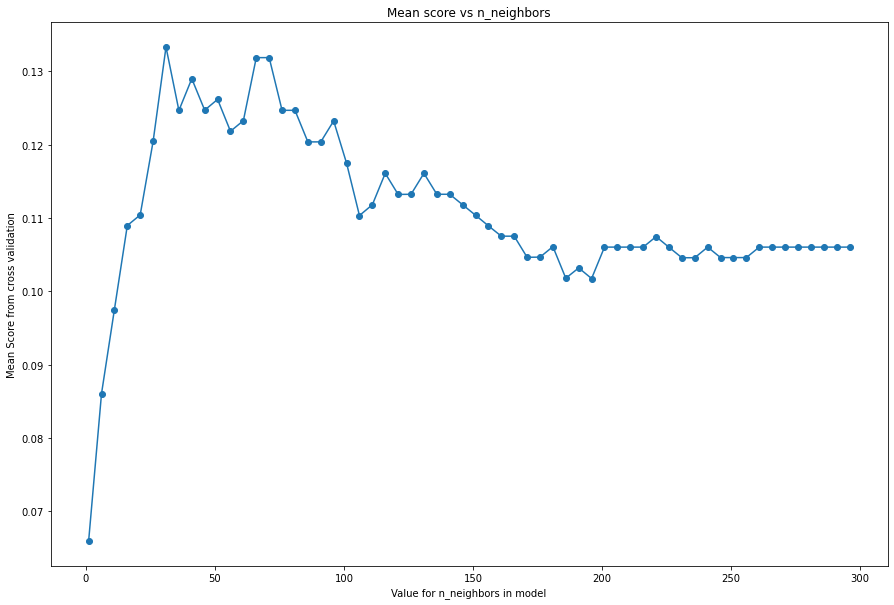

In [139]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier()
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

From the graph it seems like the ideal number of neighbors is in the range between 25 and 75. We can do a grid search of all values in that range to better visualize the space.

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


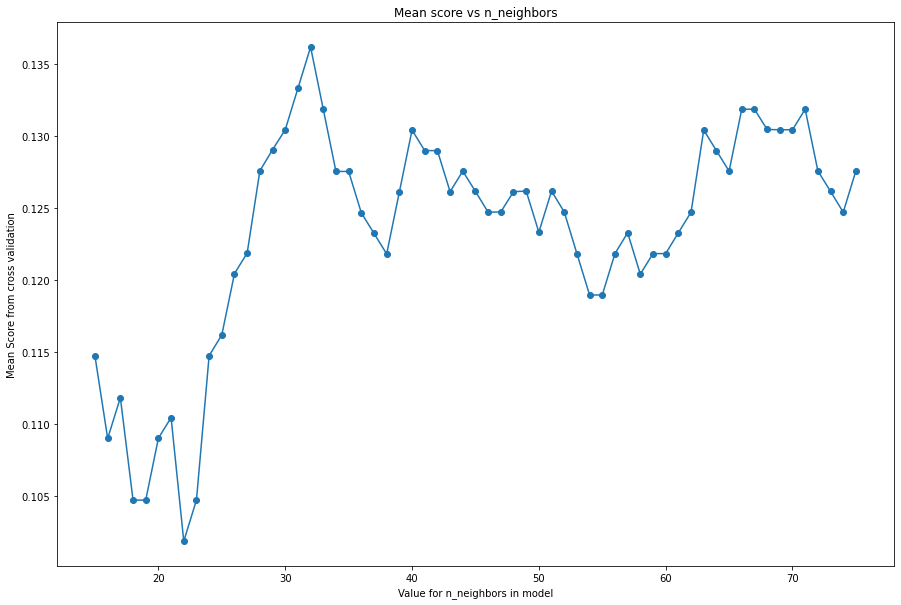

In [140]:
knn_model = KNeighborsClassifier()
test_k = range(15,75+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [141]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

32

There seems to be a peak in the data around $k = 52$ so that will be the value for k we will use in the final model.

With these hyper parameters set, we can evaulate our model's performance on the test set.

In [142]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.11587982832618025

This is a suprisingly high amount of accuracy. I believe this is actually a result of candidates having similar spending patterns over time, and since a canditate is likely to serve multiple terms for their state it makes sense that we can can predict state from spending patterns. To test this theory, I will see if we can predict a candidate based on their spending.

I should try to remake the first 2 models but with only 1 data point for each candidate

# Part 3
## Cohorts of House members and personnel spending

For this part of the project, let's consider each freshman class of members of the House. To do this, we'll have to add in data from the elections dataframe as well. Note that we are using the date of each member's last election to the house and subtracting the number of terms they have served (per the data obtained from theunitedstates.io), since we are ignoring special elections (instead, we consider specially elected members as members of the previous cohort). 

In [143]:
import re
candidate_election_res = []
spending_election_df = spending_member_info_2_party.copy()
for index, row in spending_election_df.iterrows():
    candidate_res = (election_data[election_data['candidate'].str.contains(row['LASTNAME'], flags=re.IGNORECASE) & election_data['state'].str.contains(row['STATE'], flags=re.IGNORECASE)])
    if not candidate_res.empty:
        spending_election_df.loc[index, 'FIRST_ELECTED'] = candidate_res['year'].max() - int((row['TERMS'] - 1) * 2)

spending_election_df.dropna(subset=['FIRST_ELECTED'], inplace=True)

spending_election_df = spending_election_df[spending_election_df['FIRST_ELECTED'] >= 2010]
spending_election_df

KeyError: 'TERMS'

Here we have the spending dataframe from before, but now with the election data added. The "FIRST_ELECTED" column contains the election in which each member of the House was first elected. Since we are only concerned with evaluating the spending patterns of new cohorts of members of Congress, we need to have spending data for their entire congressional tenure - meaning that we need to drop any rows where "FIRST_ELECTED" is NaN (since these people were elected before 2010 and not subsequently re-elected), and any members whose first term started before 2010. 

As an example of this, we can generate violin plots of each cohort's spending on different categories. For example, we'll plot personnel compensation and travel. 

Text(0.5, 1.0, 'Cohorts of freshmen members of congress and their spending on personnel compensation')

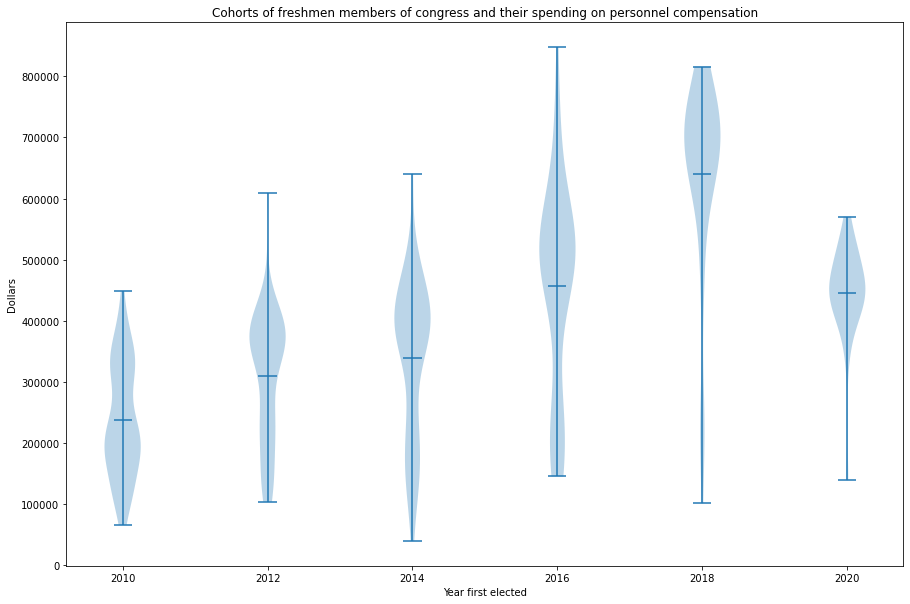

In [ ]:
fig, ax = plt.subplots()
spending_cohort = []
for year in spending_election_df.FIRST_ELECTED.unique():
    spending_cohort.append(spending_election_df[spending_election_df.FIRST_ELECTED.eq(year)]['PERSONNEL COMPENSATION'])

ax.violinplot(spending_cohort, spending_election_df['FIRST_ELECTED'].unique(), showmeans=True)
ax.set_xlabel("Year first elected")
ax.set_ylabel("Dollars")
ax.set_title("Cohorts of freshmen members of congress and their spending on personnel compensation")

Text(0.5, 1.0, 'Cohorts of freshmen members of congress and their spending on travel')

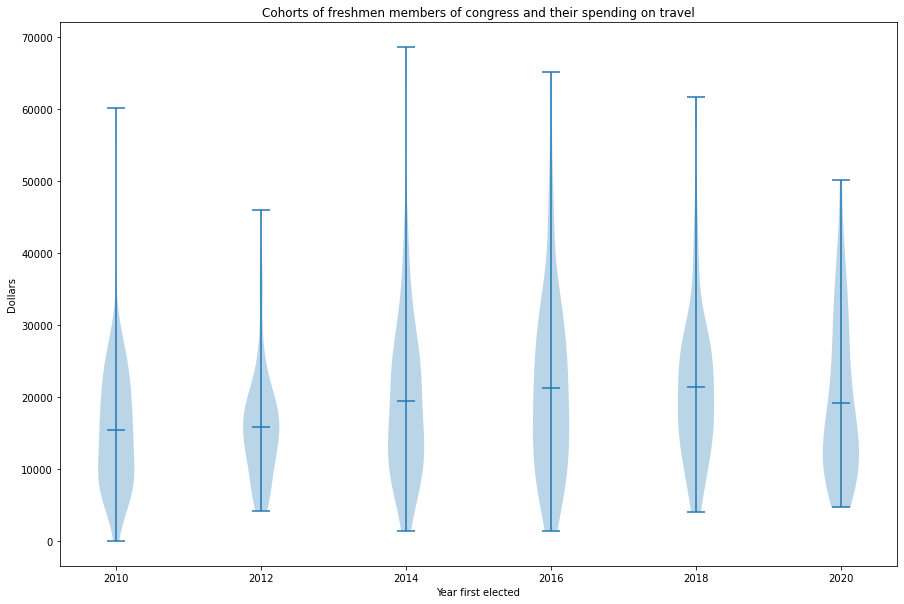

In [ ]:
fig, ax = plt.subplots()
spending_cohort = []
for year in spending_election_df.FIRST_ELECTED.unique():
    spending_cohort.append(spending_election_df[spending_election_df.FIRST_ELECTED.eq(year)]['TRAVEL'])

ax.violinplot(spending_cohort, spending_election_df['FIRST_ELECTED'].unique(), showmeans=True)
ax.set_xlabel("Year first elected")
ax.set_ylabel("Dollars")
ax.set_title("Cohorts of freshmen members of congress and their spending on travel")

We can see that personnel compensation was much higher for members of congress initially elected in 2018. From here, we can suggest our null hypothesis (the default condition): that there is no correlation between the year a member of the House was initially elected and the amount they paid their staff. 

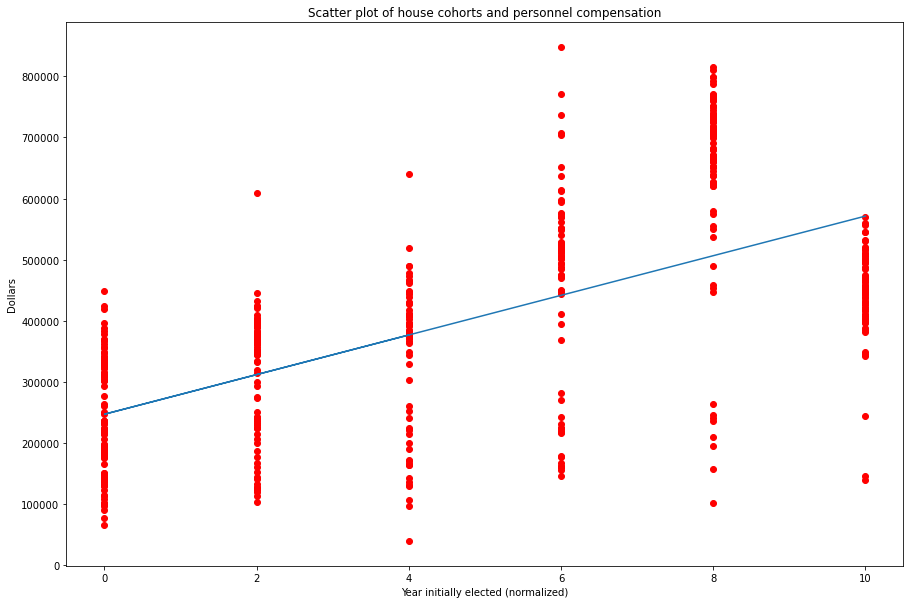

In [ ]:
spending_election_df['NORMALIZED_COHORT'] = spending_election_df['FIRST_ELECTED'] - 2010
plt.plot(spending_election_df['NORMALIZED_COHORT'], spending_election_df['PERSONNEL COMPENSATION'], 'ro')
plt.title("Scatter plot of house cohorts and personnel compensation")
plt.xlabel("Year initially elected (normalized)")
plt.ylabel("Dollars")
(m, b) = np.polyfit(spending_election_df['NORMALIZED_COHORT'].values, spending_election_df['PERSONNEL COMPENSATION'].values, 1)
plt.plot(spending_election_df['NORMALIZED_COHORT'].values, b + m * spending_election_df['NORMALIZED_COHORT'].values, '-')
plt.show()

In [ ]:
import statsmodels.formula.api as smf
spending_election_df.rename(columns={ 'PERSONNEL COMPENSATION': 'PERSONNEL_COMPENSATION'}, inplace=True)
new_model = smf.ols(formula='PERSONNEL_COMPENSATION ~ NORMALIZED_COHORT', data=spending_election_df).fit()
summary = new_model.summary()

results_as_html = summary.tables[1].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,247300.0,11100.000,22.227,0.0,225000.0,269000.0
NORMALIZED_COHORT,32400.0,1892.941,17.119,0.0,28700.0,36100.0


After running our P-test, we can see that there is a statistical correlation between the cohort (in this case its normalized form), and the amount that each member of the house spent on paying their legislative staff. We can therefore reject the null hypothesis and conclude that there is a statistically significant correlation between freshman class and the amount spent on each member's office staff. 